In [1]:
import os

import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients, Saliency
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda', index=0)

In [5]:
%cd ..

/home/rlabs/Unsupervised-NMT-for-Sumerian-English_1


In [6]:
from translation.XLM.XLM.src.utils import AttrDict
from translation.XLM.XLM.src.utils import bool_flag, initialize_exp
from translation.XLM.XLM.src.data.dictionary import Dictionary
from translation.XLM.XLM.src.model.transformerIn import TransformerModel
import pandas as pd

FAISS library was not found.
FAISS not available. Switching to standard nearest neighbors search implementation.


In [7]:
# replace <PATH-TO-SAVED-MODEL> with the real path of the saved model
model_path = 'translation/XLM/experiments/SSupervised_AugmentedData_10x/a6znr01btr/checkpoint.pth'
params_path = 'translation/XLM/experiments/SSupervised_AugmentedData_10x/a6znr01btr/params.pkl'

# load params
params = pd.read_pickle(params_path)

# load model
reloaded = torch.load(model_path)
model_params = AttrDict(reloaded['params'])

# build dictionary / build encoder / build decoder / reload weights
dico = Dictionary(reloaded['dico_id2word'], reloaded['dico_word2id'], reloaded['dico_counts'])
encoder = TransformerModel(model_params, dico, is_encoder=True, with_output=True).cuda().eval()
decoder = TransformerModel(model_params, dico, is_encoder=False, with_output=True).cuda().eval()

encoder.zero_grad()
decoder.zero_grad()

encoder.load_state_dict(reloaded['encoder'])
decoder.load_state_dict(reloaded['decoder'])
src_id = model_params.lang2id['sum']
tgt_id = model_params.lang2id['en']

In [8]:
import os
save_name = 'interpretability/imgs/' + model_path.split('/')[-3] + '/'
if not os.path.exists(save_name):
    os.mkdir(save_name)

In [9]:
dico.index('you'), dico[120]

(120, 'you')

In [10]:
for name in ['n_words', 'bos_index', 'eos_index', 'pad_index', 'unk_index', 'mask_index']:
    setattr(params, name, getattr(model_params, name))

In [11]:
def tokeniser(src_sent):
    for i in range(0, len(src_sent), params.batch_size):
        # prepare batch
        word_ids = [torch.LongTensor([dico.index(w) for w in s.strip().split()])
                    for s in src_sent[i:i + params.batch_size]]
        lengths = torch.LongTensor([len(s) + 2 for s in word_ids])
        batch = torch.LongTensor(lengths.max().item(), lengths.size(0)).fill_(params.pad_index)
        batch[0] = params.eos_index
        for j, s in enumerate(word_ids):
            if lengths[j] > 2:  # if sentence not empty
                batch[1:lengths[j] - 1, j].copy_(s)
            batch[lengths[j] - 1, j] = params.eos_index

    return batch.reshape(1,-1)

In [12]:
def predict(batch, ground_truth_tokens, langs2=None, lengths2=None, langs=None, positions=None, find_emb=True, all_embs=False, ret_out=True):
    # encode source batch and translate it
    bsz = batch.shape[0]
    ground_truth_tokens = ground_truth_tokens.reshape(-1, bsz)
    
    if(langs == None):
        batch = batch.reshape(-1, bsz)
        langs = batch.clone().fill_(src_id)
    else:
        if not all_embs:
            langs = langs.reshape(-1, bsz)
    if not find_emb:
        lengths = [batch.shape[1]]*bsz
    else:
        lengths = [batch.shape[0]]*bsz
        
    lengths = torch.tensor(lengths)   
    
    if(langs2 == None or lengths2 == None):
        langs2 = ground_truth_tokens.clone().fill_(tgt_id)
        lengths2 = torch.tensor([ground_truth_tokens.shape[0]]*bsz)
    else:
        if not all_embs:
            langs2 = langs2.reshape(-1, bsz)
        else:
            langs2 = langs2.reshape(bsz,-1)
        
    encoded = encoder('fwd', x=batch.cuda(), lengths=lengths.cuda(), find_emb=find_emb, all_embs=all_embs, langs=langs.cuda(), positions=positions, causal=False)
    encoded = encoded.transpose(0, 1)
    last = decoder('fwd', x=ground_truth_tokens.cuda(), lengths=lengths2.cuda(), langs=langs2.cuda(), causal=True, src_enc=encoded, src_len=lengths.cuda(), find_emb=True, all_embs=all_embs)
    
    pred_mask = ground_truth_tokens.clone().fill_(1).byte()
    
    y = ground_truth_tokens.masked_select(pred_mask)
    
    scores = decoder.predict(last, pred_mask, y.cuda(), get_scores=True)[0]
    
    return scores.reshape(-1,bsz,params.n_words)

In [13]:
def nmt_forward_func(inputs, ground_truth_tokens, langs2=None, lengths2=None, langs=None, position=0, find_emb=True, all_embs=False, positions=None):
    
    scores = predict(inputs,
                     ground_truth_tokens,
                     langs2, 
                     lengths2,
                     langs,
                     positions,
                     find_emb,
                     ret_out=False,
                     all_embs=all_embs
                    )
    
    return scores[position]

In [14]:
def construct_input_ref_pair(src_sent):
    text_ids = list(tokeniser([input_text])[0][1:-1].detach().cpu().numpy())
    
    input_ids = [params.eos_index] + text_ids + [params.eos_index]
    
    ref_ids = [params.eos_index] + [params.pad_index]*len(text_ids) + [params.eos_index]
    
    return torch.tensor([input_ids], device=device), text_ids, torch.tensor([ref_ids], device=device), len(text_ids)

def construct_input_ref_lang_type_pair(input_ids):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[src_id]*seq_len], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.expand_as(input_ids)
    ref_position_ids = ref_position_ids.expand_as(input_ids)
    return position_ids, ref_position_ids
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

In [15]:
# position_embeddings
# lang_embeddings
# embeddings

In [16]:
input_text = 'kiszib3 gu-du-du 1(gesz2) 1(u) la2 1(disz) geme2 u4 1(disz)-sze3 kab2-ku5 u2-du-...'
input_ids, text_ids, ref_input_ids, sep_id = construct_input_ref_pair(input_text)
lang_type_ids, ref_lang_type_ids = construct_input_ref_lang_type_pair(input_ids)
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)
indices = input_ids[0].detach().tolist()

In [17]:
ground_truth = 'under seal of gududu 69 workdays at the reservoir of udu 138 workdays at the reservoir of the erected wall and the'

ground_truth_tokens = tokeniser([ground_truth])

In [18]:
input_ids

tensor([[   1,   53, 1271,    3,    3,   88,    3,  136,   38,    3,  919,    3,
            1]], device='cuda:0')

In [19]:
def to_out(decoded):
    decoded=decoded.reshape(-1,1)
    for j in range(decoded.size(1)):
        # remove delimiters
        sent = decoded[:, j]
        delimiters = (sent == params.eos_index).nonzero().view(-1)
        assert len(delimiters) >= 1 and delimiters[0].item() == 0
        sent = sent[1:] if len(delimiters) == 1 else sent[1:delimiters[1]]
        
        target = " ".join([dico[sent[k].item()] for k in range(len(sent))])
        
    return target

In [20]:
# target, scores = predict(input_ids)
scores = predict(input_ids, ground_truth_tokens)

print('Source Sentence: ', input_text)

Source Sentence:  kiszib3 gu-du-du 1(gesz2) 1(u) la2 1(disz) geme2 u4 1(disz)-sze3 kab2-ku5 u2-du-...


In [21]:
torch.tensor(input_ids.cpu().numpy().tolist()*2).cuda()

tensor([[   1,   53, 1271,    3,    3,   88,    3,  136,   38,    3,  919,    3,
            1],
        [   1,   53, 1271,    3,    3,   88,    3,  136,   38,    3,  919,    3,
            1]], device='cuda:0')

In [22]:
torch.tensor(ground_truth_tokens.cpu().numpy().tolist()*2).cuda()

tensor([[    1,   202,   237,    28,     3, 12728,   395,   108,    24,  2355,
            28,    45, 14904,   395,   108,    24,  2355,    28,    24,   706,
           787,    54,    24,     1],
        [    1,   202,   237,    28,     3, 12728,   395,   108,    24,  2355,
            28,    45, 14904,   395,   108,    24,  2355,    28,    24,   706,
           787,    54,    24,     1]], device='cuda:0')

In [23]:
# target, scores = predict(input_ids)
scores = predict(torch.tensor(input_ids.cpu().numpy().tolist()*2).cuda(), 
                 torch.tensor(ground_truth_tokens.cpu().numpy().tolist()*2).cuda())

print('Source Sentence: ', input_text)

Source Sentence:  kiszib3 gu-du-du 1(gesz2) 1(u) la2 1(disz) geme2 u4 1(disz)-sze3 kab2-ku5 u2-du-...


In [24]:
scores.max(1)

torch.return_types.max(
values=tensor([[ -3.8646,   8.5738,  -8.7533,  ...,  -0.8373,  -3.4529,  -3.3968],
        [ -4.3638,   9.8817,  -4.8871,  ...,   1.6781,  -2.5006,  -0.0927],
        [ -7.3115,  15.9727, -12.3266,  ...,  -1.1907,  -7.8428,  -4.5278],
        ...,
        [ -6.9247,  24.5904, -10.0274,  ...,   1.6300,  -5.6633,  -3.0558],
        [ -6.6661,  17.9795, -11.9772,  ...,   0.7787,  -4.4617,  -5.9373],
        [ -7.5620,  20.0455, -10.2513,  ...,   1.4772,  -2.9552,  -3.1991]],
       device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 0, 1,  ..., 1, 1, 1],
        [0, 1, 0,  ..., 1, 0, 1],
        ...,
        [1, 1, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 1],
        [1, 1, 1,  ..., 0, 0, 1]], device='cuda:0'))

## Using Interpretable Embedding Layer

In [25]:
def construct_sub_embedding(input_ids, ref_input_ids,
                                   token_lang_ids, ref_token_lang_ids,
                                   position_ids, ref_position_ids):
    input_embeddings = interpretable_embedding1.indices_to_embeddings(input_ids)
    ref_input_embeddings = interpretable_embedding1.indices_to_embeddings(ref_input_ids)

    input_embeddings_token_lang = interpretable_embedding2.indices_to_embeddings(token_lang_ids)
    ref_input_embeddings_token_lang = interpretable_embedding2.indices_to_embeddings(ref_token_lang_ids)

    input_embeddings_position_ids = interpretable_embedding3.indices_to_embeddings(position_ids)
    ref_input_embeddings_position_ids = interpretable_embedding3.indices_to_embeddings(ref_position_ids)
    
    return (input_embeddings, ref_input_embeddings), \
           (input_embeddings_token_lang, ref_input_embeddings_token_lang), \
           (input_embeddings_position_ids, ref_input_embeddings_position_ids)
    
def construct_whole_embeddings(input_ids, ref_input_ids, \
                                    token_lang_ids=None, ref_token_lang_ids=None, \
                                    position_ids=None, ref_position_ids=None):
    input_embeddings = interpretable_embedding.indices_to_embeddings(input_ids, token_lang_ids=token_lang_ids, position_ids=position_ids)
    ref_input_embeddings = interpretable_embedding.indices_to_embeddings(ref_input_ids, token_lang_ids=token_lang_ids, position_ids=position_ids)
    
    return input_embeddings, ref_input_embeddings

In [26]:
# remove_interpretable_embedding_layer(encoder, interpretable_embedding1)
# remove_interpretable_embedding_layer(encoder, interpretable_embedding2)
# remove_interpretable_embedding_layer(encoder, interpretable_embedding3)

In [27]:
interpretable_embedding1 = configure_interpretable_embedding_layer(encoder, 'embeddings')

### All layers

In [28]:
input_ids

tensor([[   1,   53, 1271,    3,    3,   88,    3,  136,   38,    3,  919,    3,
            1]], device='cuda:0')

In [29]:
def interpret_layers(src, trg):
    
    # get a list of src_tokens from the src sentence
    input_ids, text_ids, ref_input_ids, sep_id = construct_input_ref_pair(input_text)
    lang_type_ids, ref_lang_type_ids = construct_input_ref_lang_type_pair(input_ids)
    position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
    
    langs = input_ids.reshape(-1,1).clone().fill_(src_id)
    lengths = torch.tensor([input_ids.shape[1]]*input_ids.shape[0])
    
    # get a list of trg_tokens from the trg sentence
    ground_truth_tokens = tokeniser([trg])
    
    langs2 = ground_truth_tokens.reshape(-1,1).clone().fill_(tgt_id)
    lengths2 = torch.tensor([ground_truth_tokens.shape[1]]*ground_truth_tokens.shape[0])
    
    # pre-computing word embeddings
    input_embed = interpretable_embedding1.indices_to_embeddings(input_ids)
    ref_input_embed = interpretable_embedding1.indices_to_embeddings(ref_input_ids)
    
    src_embedding = input_embed # + position_ids_embed.expand_as(input_embed) + token_lang_ids_embed
    
    # get outputs tensor [seq_length, batch_size, trg_vocab_size]
    outputs = predict(src_embedding, ground_truth_tokens, langs= langs, find_emb=False, ret_out=False)
    
    output_tokens = []
    attribution_igs = [] # size: [len(output_tokens), len(src_tokens)]
    for i in range(encoder.n_layers):
        output_token = []
        attribution_ig = []
        lc = LayerConductance(nmt_forward_func, encoder.attentions[i])
        for idx, output in enumerate(outputs):
            max_idx = output.max(1).indices.item()
            output_t = dico[max_idx]
            output_token.append(output_t)
            langs=langs.reshape(1,-1)
            langs2=langs2.reshape(1,-1)
            attribution, delta =  lc.attribute(src_embedding, baselines=0, additional_forward_args=(ground_truth_tokens, langs2, lengths2, langs, idx, False), target=max_idx, n_steps=10, return_convergence_delta=True)
            attribution_ig.append(attribution)
            
        output_tokens.append(output_token)
        attribution_igs.append(attribution_ig)
    
    return attribution_igs, output_tokens

In [30]:
attribution_igs_attn, output_tokens_attn = interpret_layers(input_text, ground_truth)

In [31]:
import seaborn as sns

In [32]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

In [33]:
def pdf_attr(attrs, bins=100):
    return np.histogram(attrs, bins=bins, density=True)[0]

In [34]:
def draw_pdf_plot(inp, token_to_explain, attribution_igs=attribution_igs_attn, output_tokens=output_tokens_attn):
    attrs=[]
    outs=[]
    attrs_dist=[]
    for i in range(4):
        attrs_dist.append(attribution_igs[i][inp][0, token_to_explain, :].cpu().detach().tolist())
        outs.append(output_tokens[i][inp])
        
    layer_attrs_pdf = map(lambda attrs_dist: pdf_attr(attrs_dist), attrs_dist)
    layer_attrs_end_pdf = np.array(list(attrs_dist))

    # summing attribution along embedding diemension for each layer
    # size: #layers
    attr_sum = np.array(attrs_dist).sum(-1)

    # size: #layers
    layer_attrs_end_pdf_norm = np.linalg.norm(layer_attrs_end_pdf, axis=-1, ord=1)

    #size: #bins x #layers
    layer_attrs_end_pdf = np.transpose(layer_attrs_end_pdf)

    #size: #bins x #layers
    layer_attrs_end_pdf = np.divide(layer_attrs_end_pdf, layer_attrs_end_pdf_norm, where=layer_attrs_end_pdf_norm!=0)
    
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot(layer_attrs_end_pdf[:100])
    plt.xlabel('Bins')
    plt.ylabel('Density')
    plt.legend(['Layer '+ str(i) for i in range(1,5)])
    plt.title('Between \'' + output_tokens[0][inp] + '\' and \'' + input_text.split()[token_to_explain-1] + '\'')
    plt.savefig(save_name + '_layerhist_' + str(inp) + '.png')
    plt.show()

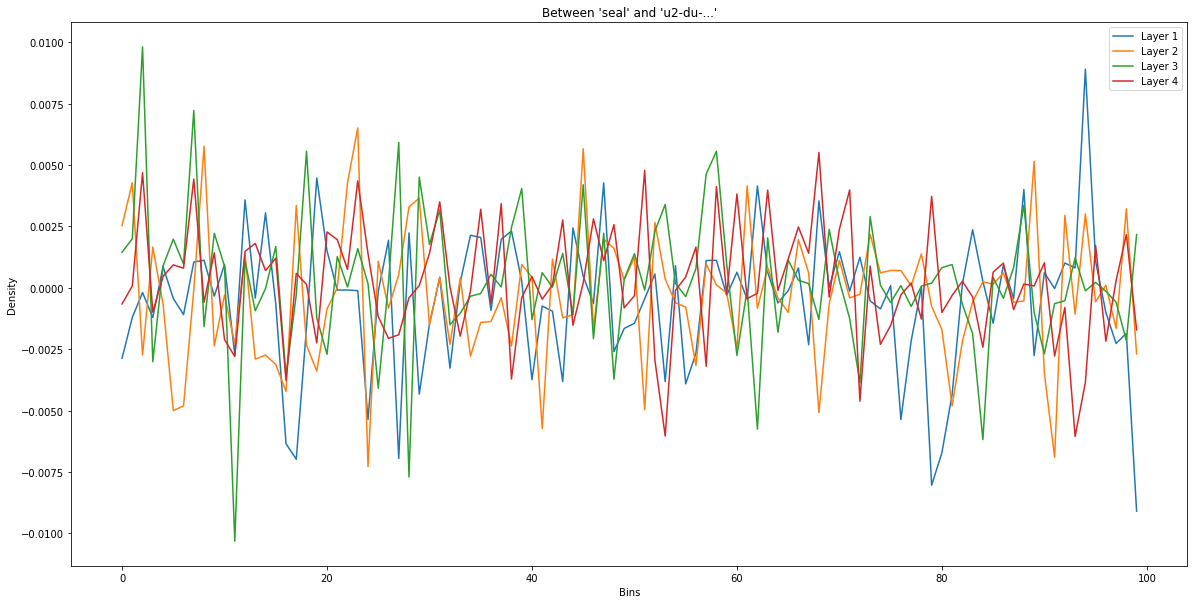

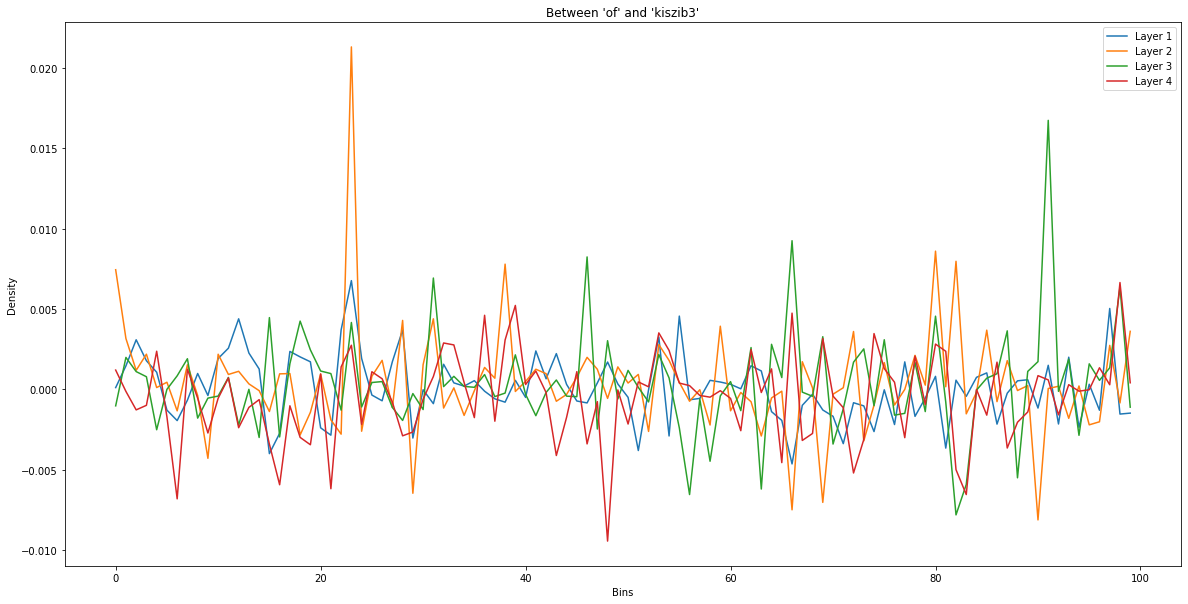

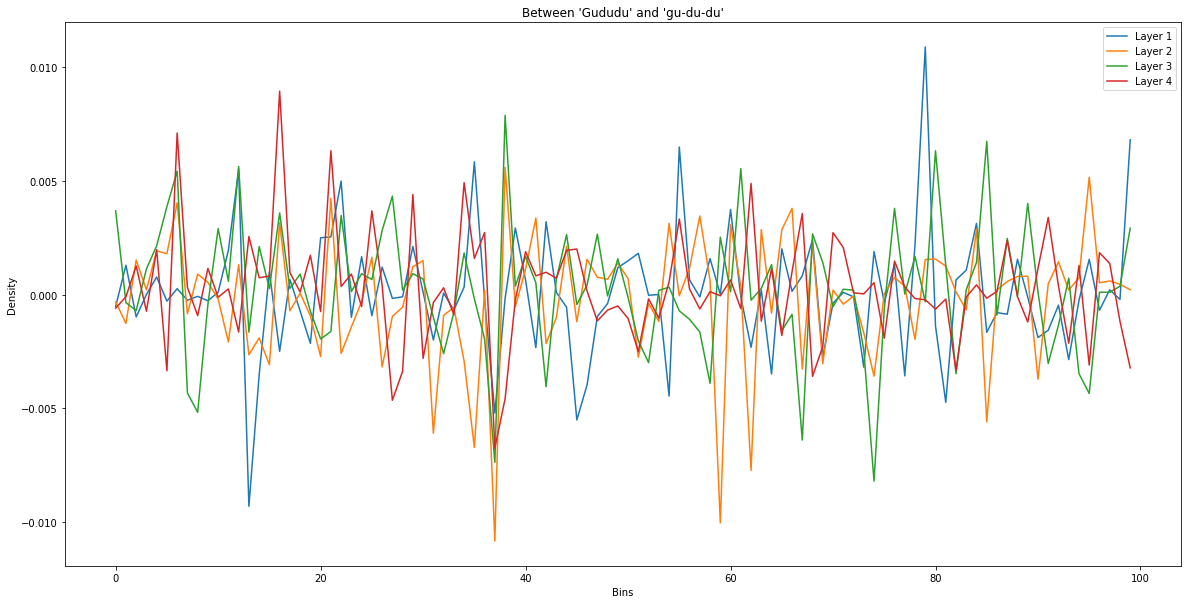

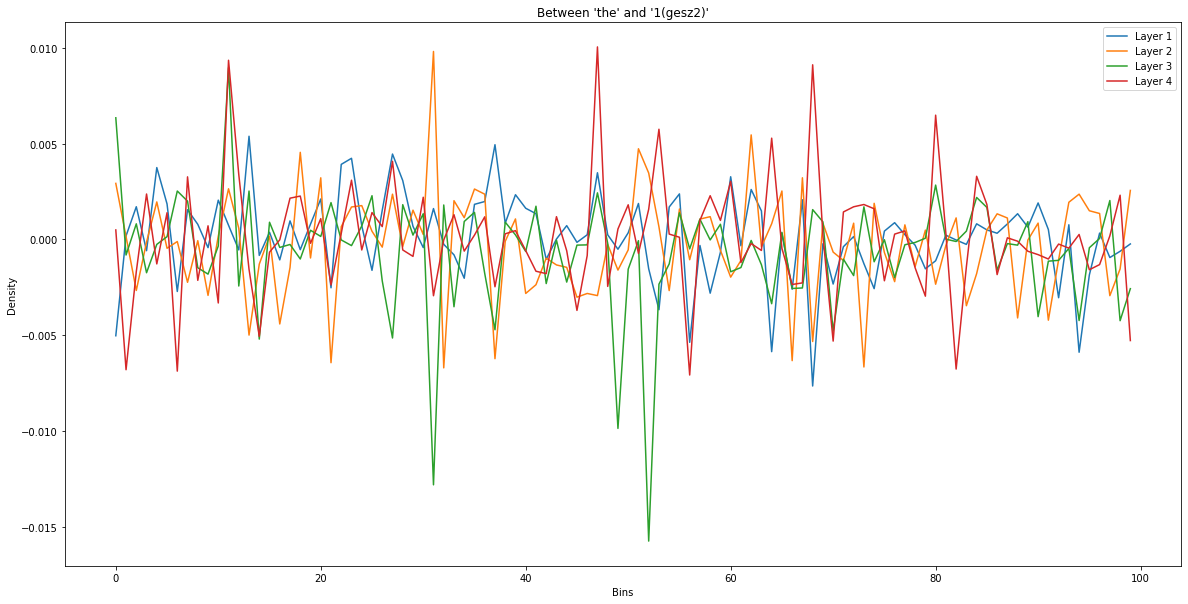

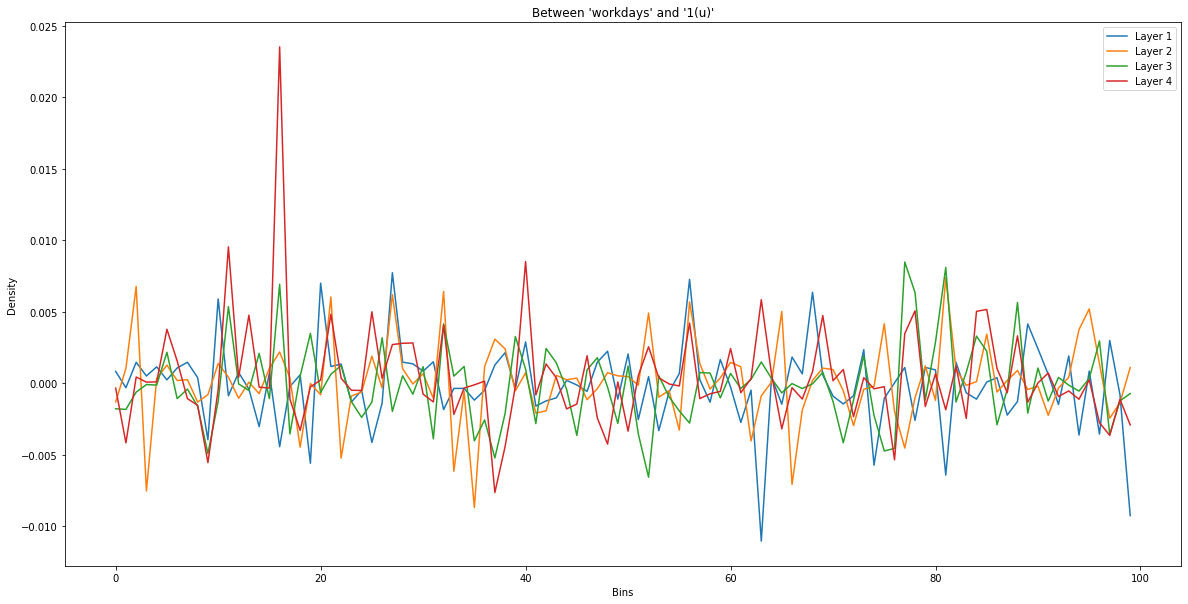

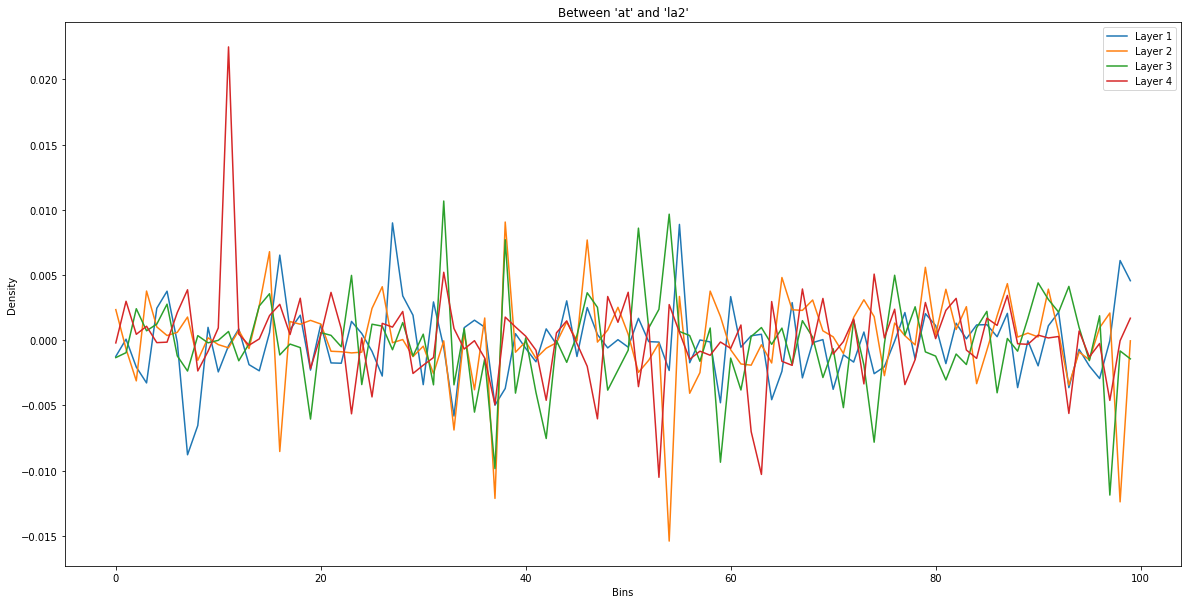

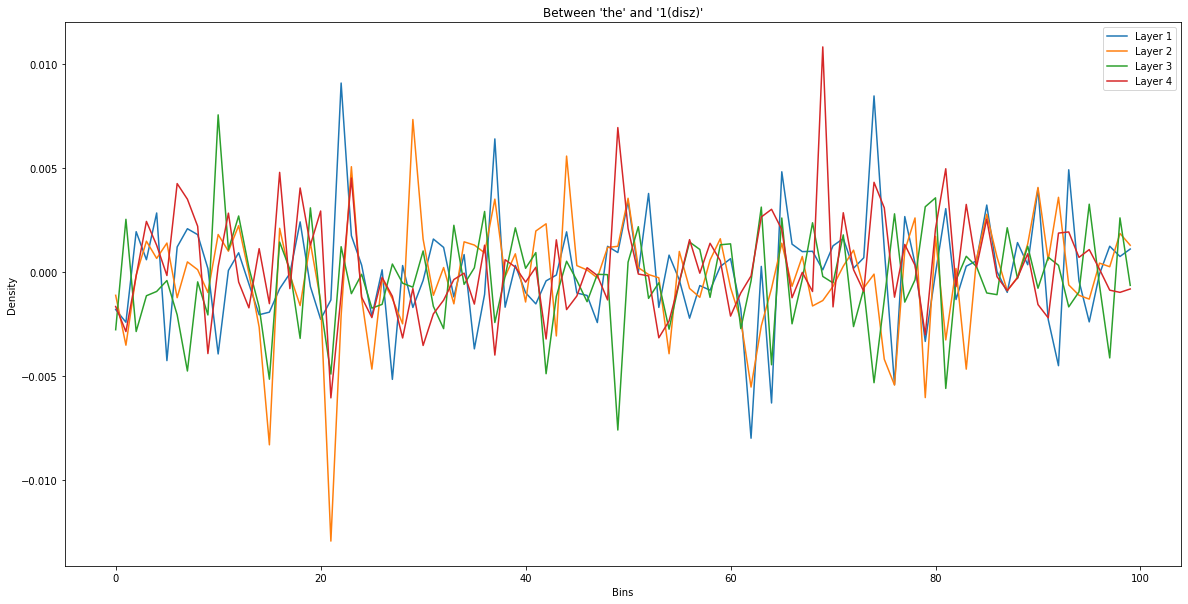

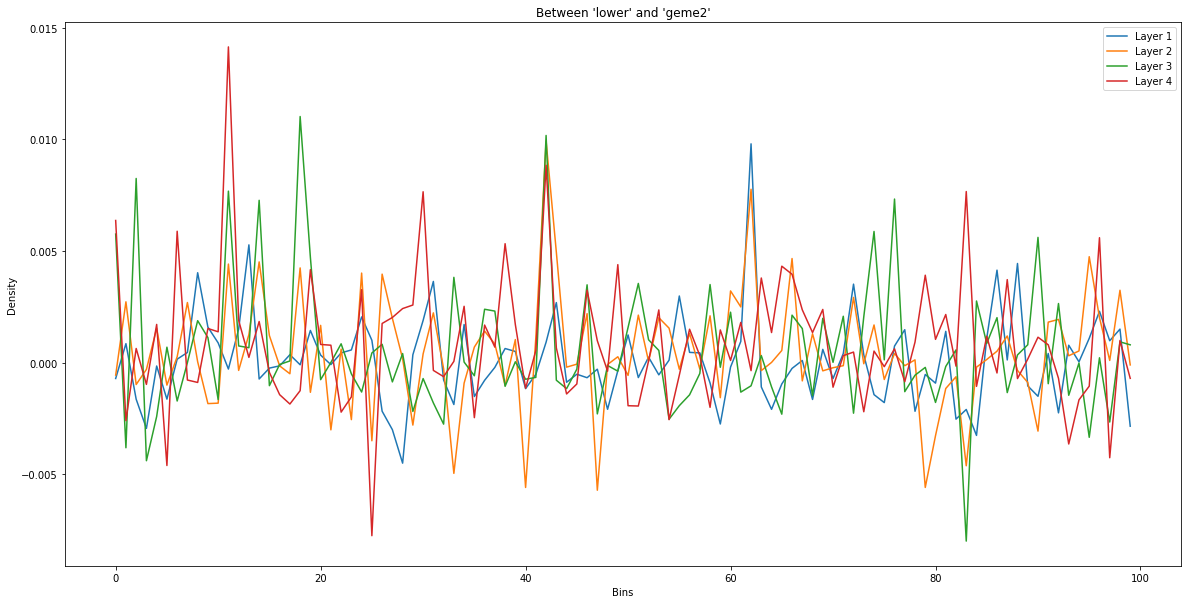

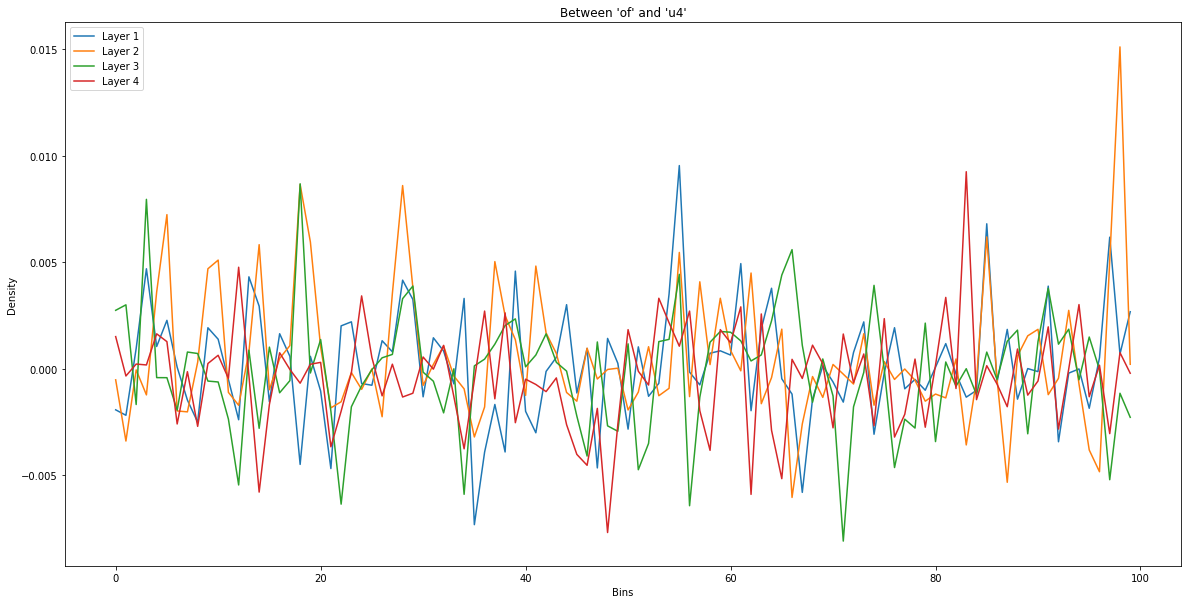

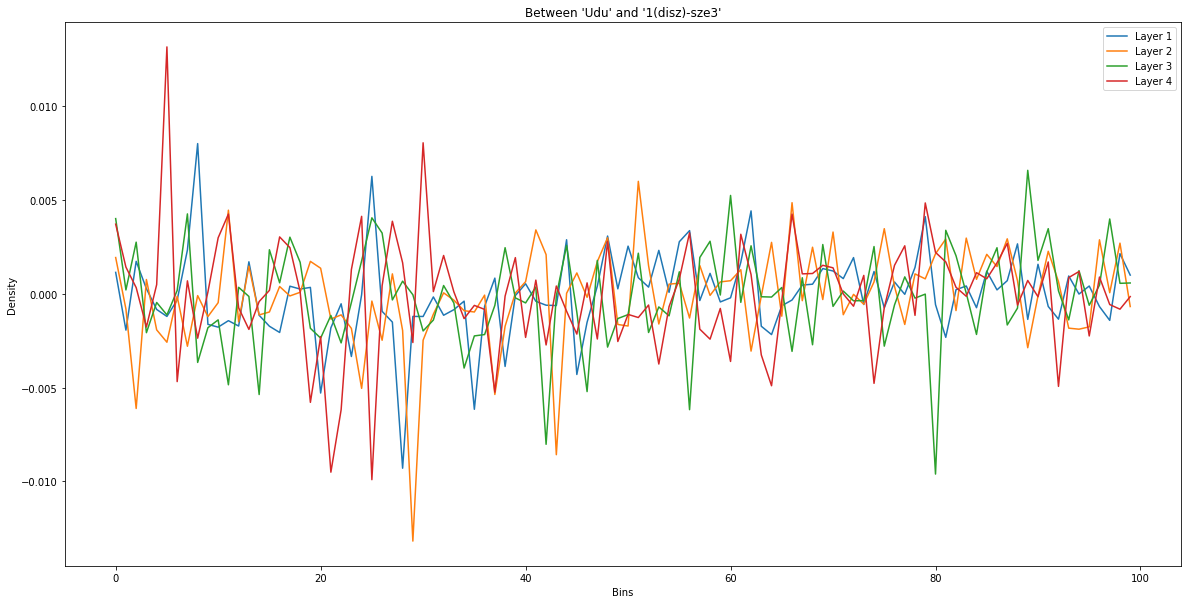

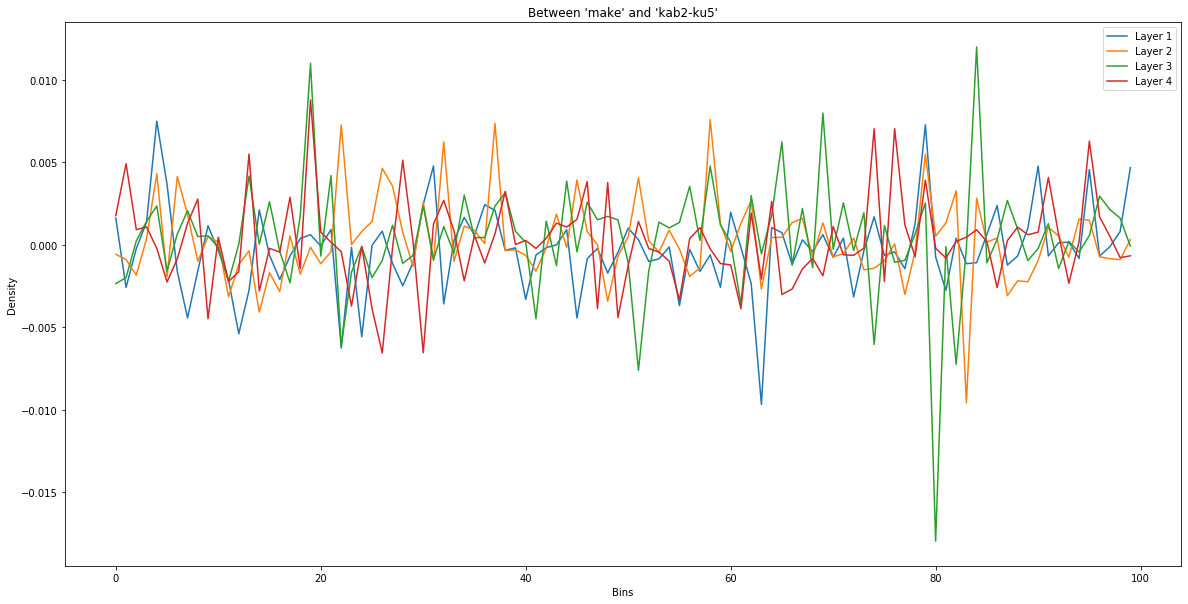

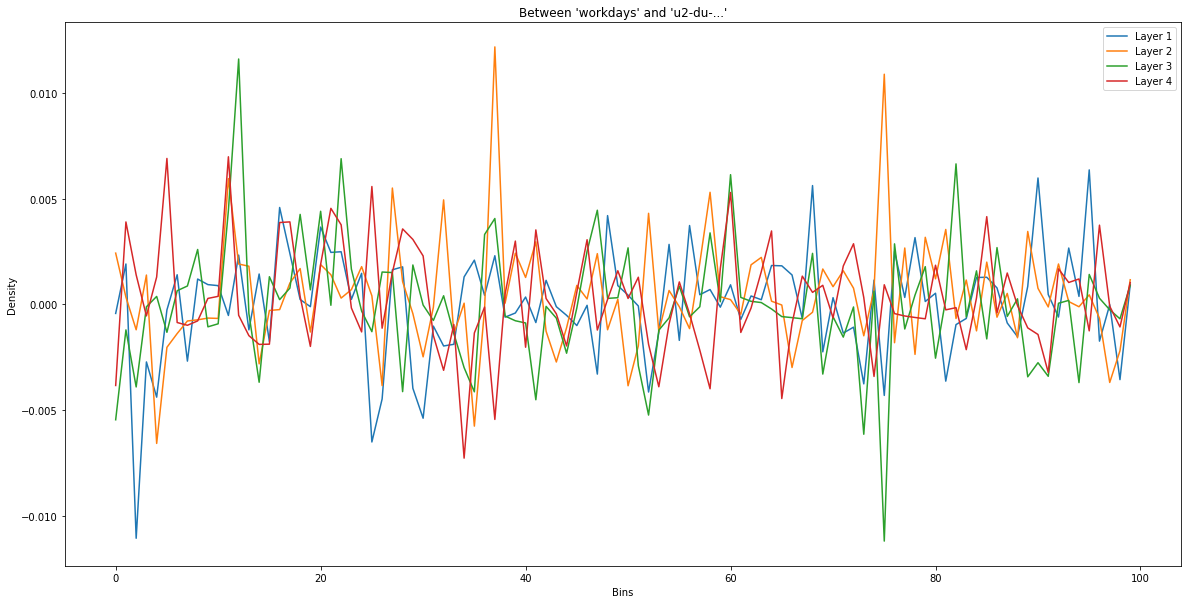

In [35]:
for i in range(len(input_ids[0])-1):
    draw_pdf_plot(i+1, i)

In [36]:
def draw_box_plot(inp, attribution_igs=attribution_igs_attn, output_tokens=output_tokens_attn):
    attrs_first=[]
    outs_first=[]
    attrs_first_dist=[]
    token_to_explain=10
    for i in range(4):
        attrs_first_dist.append(attribution_igs[i][inp][0, token_to_explain, :].cpu().detach().tolist())
        outs_first.append(output_tokens[i][inp])
    fig, ax = plt.subplots(figsize=(20,10))
    
    print(len(attrs_first_dist), len(attrs_first_dist[0]))
    ax = sns.boxplot(attrs_first_dist)
    plt.xlabel('Layers')
    plt.ylabel('Attribution')
    plt.title(output_tokens[0][inp])
    plt.show()

4 512


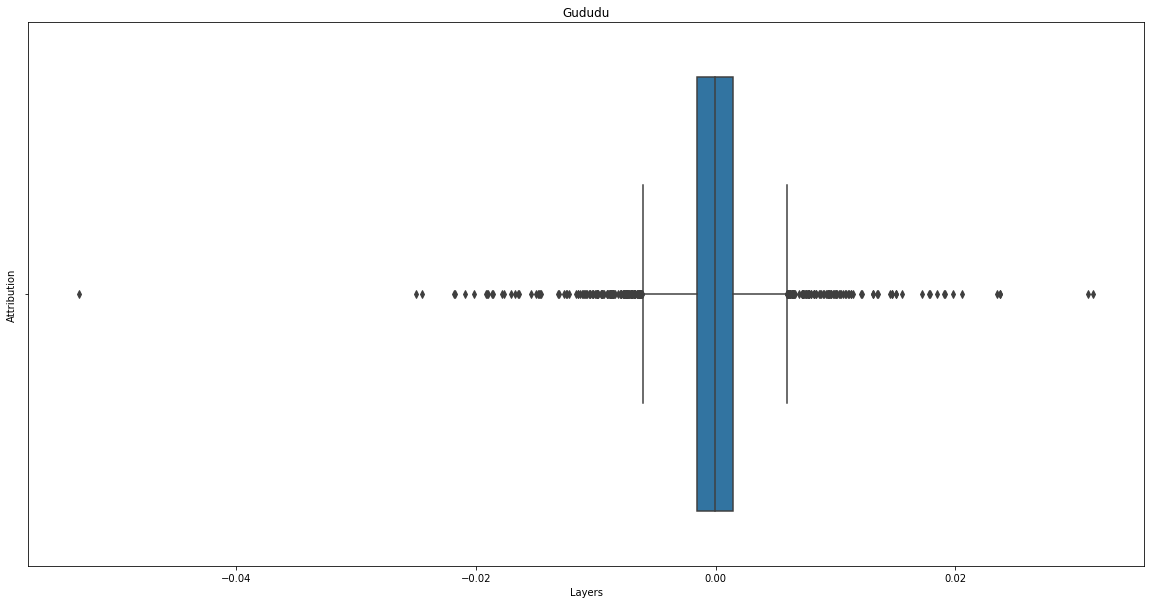

In [37]:
draw_box_plot(3)

In [38]:
def draw_heatmap_for_inp(inp, attribution_igs=attribution_igs_attn, output_tokens=output_tokens_attn):
    attrs_first=[]
    outs_first=[]

    for i in range(4):
        attrs_first.append(summarize_attributions(attribution_igs[i][inp]).detach().cpu().numpy().tolist())
        outs_first.append(output_tokens[i][inp])
    fig, ax = plt.subplots(figsize=(20,4))
    xticklabels=['<sos>']+input_text.split()+['<eos>']
    yticklabels=list(range(1,5))
    ax = sns.heatmap(np.array(attrs_first), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2)
    plt.xlabel('Tokens')
    plt.ylabel('Layers')
    plt.title(output_tokens[0][inp])
    plt.savefig(save_name + '_layerhm_' + str(inp) + '.png')
    plt.show()

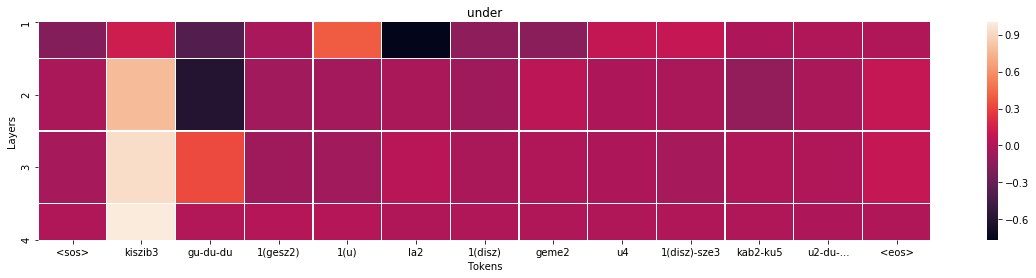

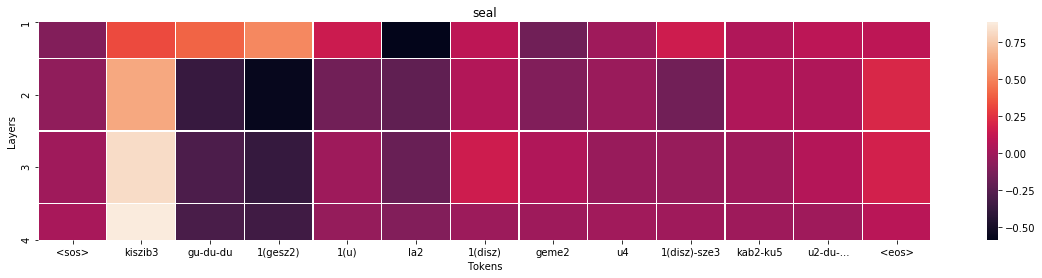

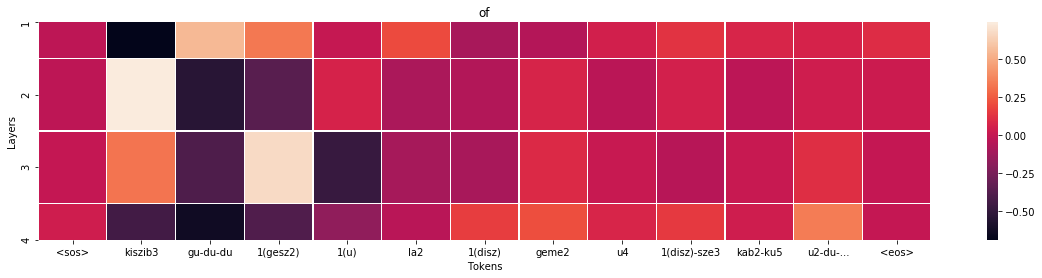

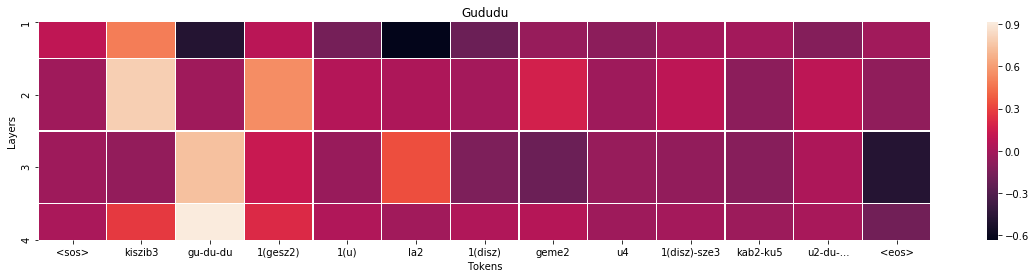

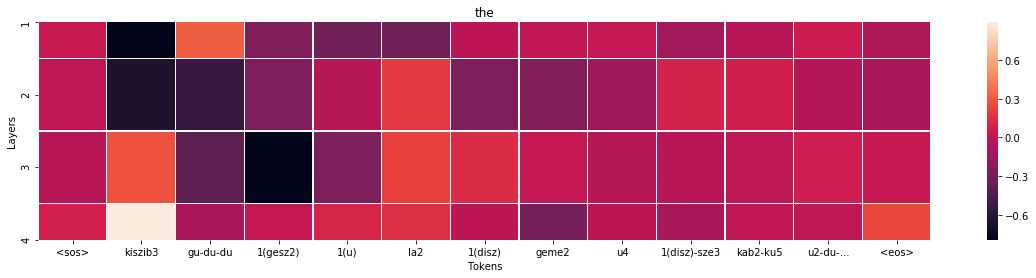

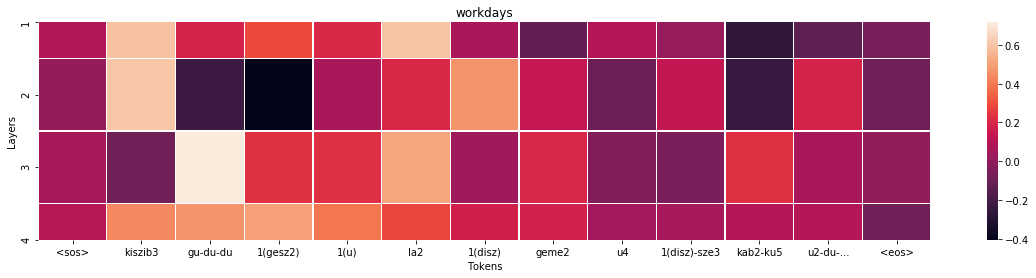

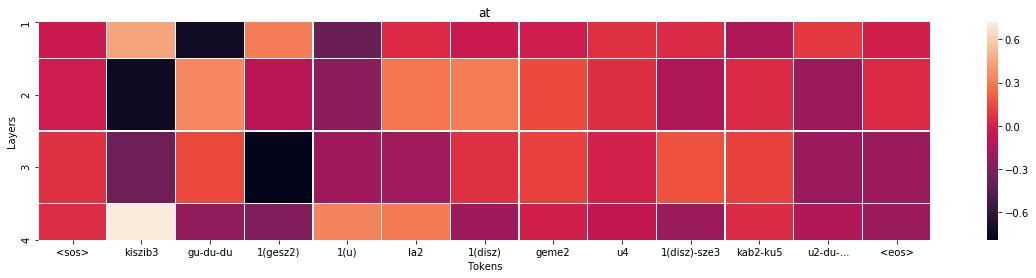

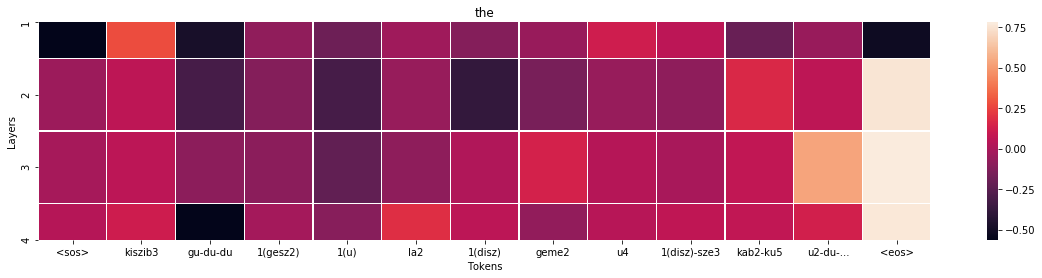

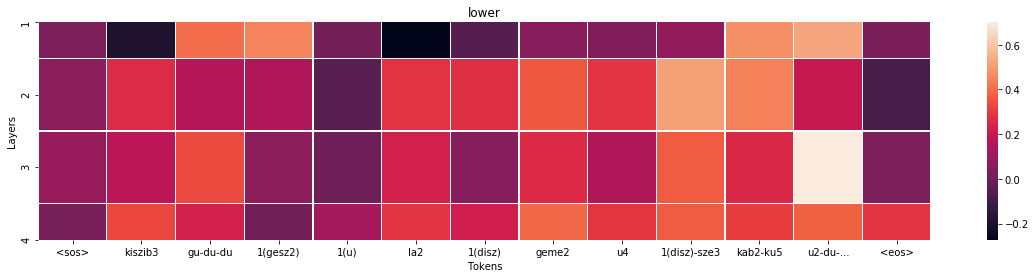

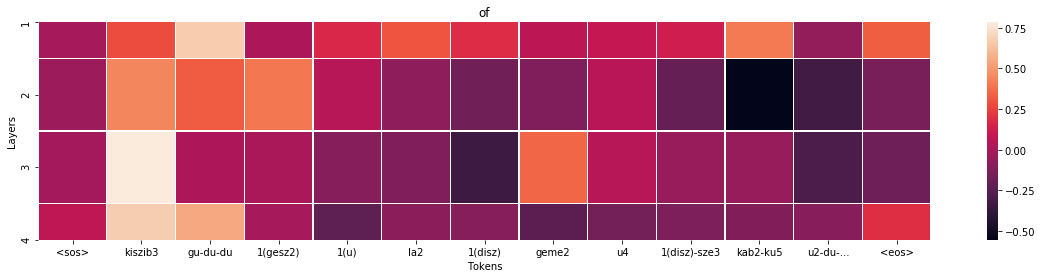

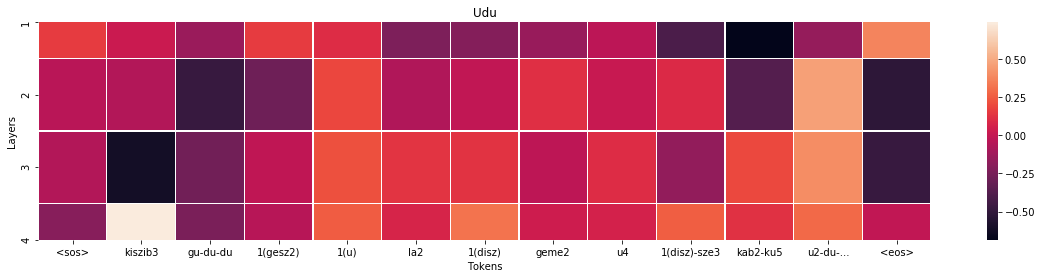

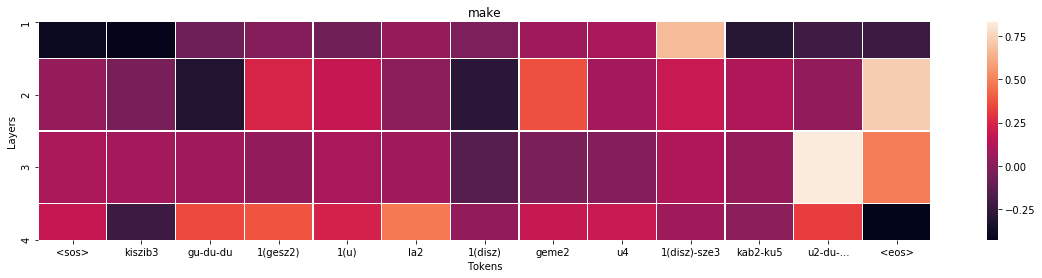

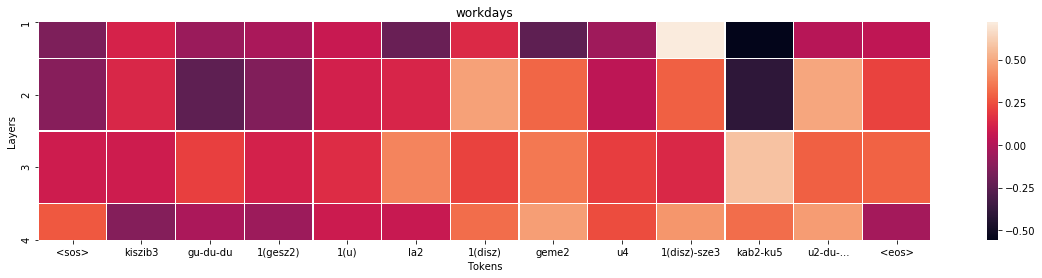

In [39]:
for index in range(len(input_ids[0])):
    draw_heatmap_for_inp(index)

In [40]:
' '.join(output_tokens_attn[0])

'under seal of Gududu the workdays at the lower of Udu make workdays at the reservoir of the Ebabbar wall and the </s> </s>'

In [41]:
ground_truth

'under seal of gududu 69 workdays at the reservoir of udu 138 workdays at the reservoir of the erected wall and the'

### Without Captum

In [42]:
def without_capt(src, trg):
    
    # get a list of src_tokens from the src sentence
    input_ids, text_ids, ref_input_ids, sep_id = construct_input_ref_pair(input_text)
    lang_type_ids, ref_lang_type_ids = construct_input_ref_lang_type_pair(input_ids)
    position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
    
    langs = input_ids.reshape(-1,1).clone().fill_(src_id)
    lengths = torch.tensor([input_ids.shape[1]]*input_ids.shape[0])
    
    # get a list of trg_tokens from the trg sentence
    ground_truth_tokens = tokeniser([trg])
    
    langs2 = ground_truth_tokens.reshape(-1,1).clone().fill_(tgt_id)
    lengths2 = torch.tensor([ground_truth_tokens.shape[1]]*ground_truth_tokens.shape[0])
    
    # pre-computing word embeddings
    input_embed = interpretable_embedding1.indices_to_embeddings(input_ids)
    ref_input_embed = interpretable_embedding1.indices_to_embeddings(ref_input_ids)
    
    src_embedding = input_embed # + position_ids_embed.expand_as(input_embed) + token_lang_ids_embed
    
    # get outputs tensor [seq_length, batch_size, trg_vocab_size]
    outputs = predict(src_embedding, ground_truth_tokens, langs = langs, find_emb=False, ret_out=False)
    
    # get output_tokens from outputs
    # compute attributions and approximation delta using integrated gradients
    output_tokens = []
    attribution_igs = [] # size: [len(output_tokens), len(src_tokens)]
    all_grads=[]
    for idx, output in enumerate(outputs):
        max_idx = output.max(1).indices.item()
        output_token = dico[max_idx]
        output_tokens.append(output_token)
        langs=langs.reshape(1,-1)
        langs2=langs2.reshape(1,-1)
        src_embedding.requires_grad_()
        with torch.autograd.set_grad_enabled(True):
            model_out = nmt_forward_func(src_embedding, ground_truth_tokens, langs2=langs2.reshape(-1,1), lengths2=lengths2, langs=langs, position=0, find_emb=False)
            selected_out = model_out[:, max_idx]
            grads = torch.autograd.grad(torch.unbind(selected_out), src_embedding, allow_unused=True)
            all_grads.append(grads)
            
    return all_grads

In [43]:
all_grads = without_capt(input_text, ground_truth)

### Integrated Gradients

In [44]:
ig = IntegratedGradients(nmt_forward_func)

In [45]:
def interpret_sentence_1(src, trg):
    
    # get a list of src_tokens from the src sentence
    input_ids, text_ids, ref_input_ids, sep_id = construct_input_ref_pair(input_text)
    lang_type_ids, ref_lang_type_ids = construct_input_ref_lang_type_pair(input_ids)
    position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
    
    langs = input_ids.reshape(-1,1).clone().fill_(src_id)
    lengths = torch.tensor([input_ids.shape[1]]*input_ids.shape[0])
    
    # get a list of trg_tokens from the trg sentence
    ground_truth_tokens = tokeniser([trg])
    
    langs2 = ground_truth_tokens.reshape(-1,1).clone().fill_(tgt_id)
    lengths2 = torch.tensor([ground_truth_tokens.shape[1]]*ground_truth_tokens.shape[0])
    
    # pre-computing word embeddings
    input_embed = interpretable_embedding1.indices_to_embeddings(input_ids)
    ref_input_embed = interpretable_embedding1.indices_to_embeddings(ref_input_ids)
    
    src_embedding = input_embed # + position_ids_embed.expand_as(input_embed) + token_lang_ids_embed
    
    # get outputs tensor [seq_length, batch_size, trg_vocab_size]
    outputs = predict(src_embedding, ground_truth_tokens, langs = langs, find_emb=False, ret_out=False)
    
    # get output_tokens from outputs
    # compute attributions and approximation delta using integrated gradients
    output_tokens = []
    attribution_igs = [] # size: [len(output_tokens), len(src_tokens)]
    for idx, output in enumerate(outputs):
        max_idx = output.max(1).indices.item()
        output_token = dico[max_idx]
        output_tokens.append(output_token)
        langs=langs.reshape(1,-1)
        langs2=langs2.reshape(1,-1)
        attribution_ig, delta =  ig.attribute(src_embedding, baselines=0, additional_forward_args=(ground_truth_tokens, langs2, lengths2, langs, idx, False), target=max_idx, n_steps=50, return_convergence_delta=True)
        attribution_igs.append(attribution_ig)
    
    return attribution_igs, output_tokens

In [46]:
attribution_igs, output_tokens = interpret_sentence_1(input_text, ground_truth)

In [47]:
attribution_igs[0].shape

torch.Size([1, 13, 512])

In [48]:
import matplotlib
import matplotlib.pyplot as plt
import numpy

def plot_attributions(attribution_igs, src, output_tokens):
    # This is an example of how we can visualize attributions.
    # We plot an attribution-based alignments between every output token and every input token.
    
    # get a list of src_tokens from the src sentence
    src_tokens = ['<sos>'] + src.split(' ') + ['<eos>']
    
    # For each output token, we aggregate and normalize attribution of each input token.
    normalized_attribution_igs = [] #size [len(output_tokens), len(src_tokens)]
    end_idx = len(output_tokens) - 1
    for idx, attribution_ig in enumerate(attribution_igs):
        # Disregard the token <eos> token at the end of the output_tokens.
        if output_tokens[idx] == params.eos_index and idx>0:
            end_idx = idx
            break
            
        attribution_ig = attribution_ig.sum(dim=2).squeeze(0)
        attribution_ig /= torch.norm(attribution_ig)
        attribution_ig = attribution_ig.detach().cpu().detach().numpy()
        normalized_attribution_igs.append(attribution_ig)
    
    normalized_attribution_igs = numpy.array(normalized_attribution_igs)
    
    return normalized_attribution_igs

In [49]:
attrs_first = plot_attributions(attribution_igs, input_text, output_tokens)

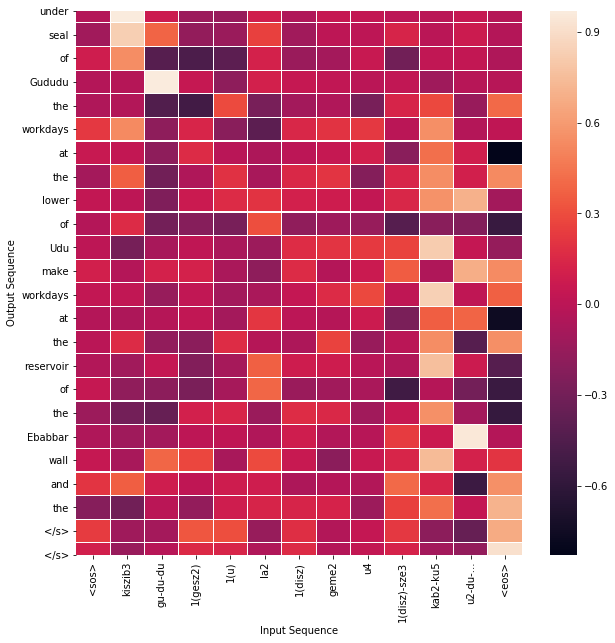

In [50]:
fig, ax = plt.subplots(figsize=(10,10))
xticklabels=['<sos>']+input_text.split()+['<eos>']
yticklabels=output_tokens
ax = sns.heatmap(np.array(attrs_first), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2)
plt.xlabel('Input Sequence')
plt.ylabel('Output Sequence')
plt.savefig(save_name + '_atthm.png')
plt.show()

In [51]:
def plot_heatmap(data, x_labels, y_labels):
    
    fig, ax = plt.subplots(figsize=(20,10))
    
    ax = plt.gca()
    
    # Plot the heatmap
    im = ax.imshow(data, cmap='RdBu', interpolation='nearest', aspect='auto')
    
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("attributions", rotation=-90, va="bottom")
    
    # how all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    print(x_labels)
    ax.set_xticklabels(x_labels)
    print(y_labels)
    ax.set_yticklabels(y_labels)
    ax.set_xlabel('Output Sequence')
    ax.set_ylabel('Input Sequence')
    
    # Turn spines off and create white grid
    for edge, spine in ax.spines.items():
        spine.set_visible(False)
    
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    
    # Set alignment to center
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update()
    
    # Get the formatter in case a string is supplied
    valfmt = "{x:.1f}"
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)
    
    # Loop over the data and assign the probablity for each output-input token alignment pair.
    # Change the color of probability depending on the value.
    textcolors =["black", "white"]
    threshold = im.norm(data.max())/2.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data[i, j] == "nan":
                continue
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)
            
    plt.savefig(save_name + '_score_map.png')

['under', 'seal', 'of', 'Gududu', 'the', 'workdays', 'at', 'the', 'lower', 'of', 'Udu', 'make', 'workdays', 'at', 'the', 'reservoir', 'of', 'the', 'Ebabbar', 'wall', 'and', 'the', '</s>', '</s>']
['<sos>', 'kiszib3', 'gu-du-du', '1(gesz2)', '1(u)', 'la2', '1(disz)', 'geme2', 'u4', '1(disz)-sze3', 'kab2-ku5', 'u2-du-...', '<eos>']


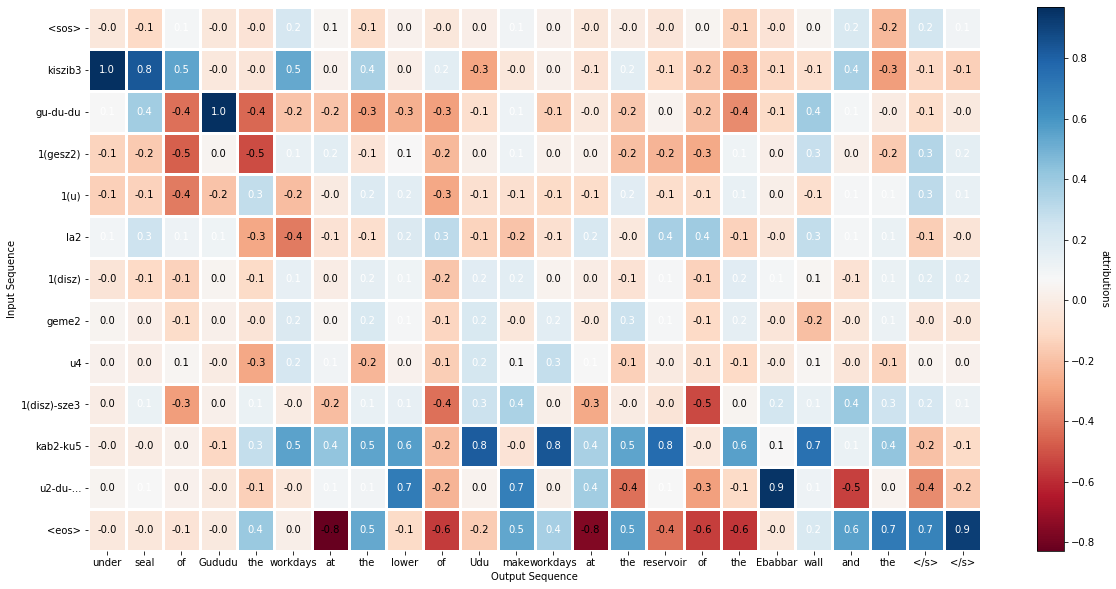

In [52]:
plot_heatmap(attrs_first[:].transpose(), output_tokens, ['<sos>'] + input_text.split(' ') + ['<eos>'])

### Saliency

In [53]:
saliency = Saliency(nmt_forward_func)

In [54]:
def interpret_sentence_saliency(src, trg):
    
    # get a list of src_tokens from the src sentence
    input_ids, text_ids, ref_input_ids, sep_id = construct_input_ref_pair(input_text)
    lang_type_ids, ref_lang_type_ids = construct_input_ref_lang_type_pair(input_ids)
    position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
    
    langs = input_ids.reshape(-1,1).clone().fill_(src_id)
    lengths = torch.tensor([input_ids.shape[1]]*input_ids.shape[0])
    
    # get a list of trg_tokens from the trg sentence
    ground_truth_tokens = tokeniser([trg])
    
    langs2 = ground_truth_tokens.reshape(-1,1).clone().fill_(tgt_id)
    lengths2 = torch.tensor([ground_truth_tokens.shape[1]]*ground_truth_tokens.shape[0])
    
    # pre-computing word embeddings
    input_embed = interpretable_embedding1.indices_to_embeddings(input_ids)
    ref_input_embed = interpretable_embedding1.indices_to_embeddings(ref_input_ids)
    
    src_embedding = input_embed # + position_ids_embed.expand_as(input_embed) + token_lang_ids_embed
    
    # get outputs tensor [seq_length, batch_size, trg_vocab_size]
    outputs = predict(src_embedding, ground_truth_tokens, langs = langs, find_emb=False, ret_out=False)
    
    # get output_tokens from outputs
    # compute attributions and approximation delta using integrated gradients
    output_tokens = []
    attribution_igs = [] # size: [len(output_tokens), len(src_tokens)]
    for idx, output in enumerate(outputs):
        print(idx)
        max_idx = output.max(1).indices.item()
        output_token = dico[max_idx]
        output_tokens.append(output_token)
        langs=langs.reshape(1,-1)
        langs2=langs2.reshape(1,-1)
        attribution_ig =  saliency.attribute(src_embedding, additional_forward_args=(ground_truth_tokens, langs2, lengths2, langs, idx, False), target=max_idx)
        attribution_igs.append(attribution_ig)
    
    return attribution_igs, output_tokens

In [55]:
attribution_igs_sal, output_tokens_sal = interpret_sentence_saliency(input_text, ground_truth)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [56]:
attrs_sal = plot_attributions(attribution_igs_sal, input_text, output_tokens_sal)

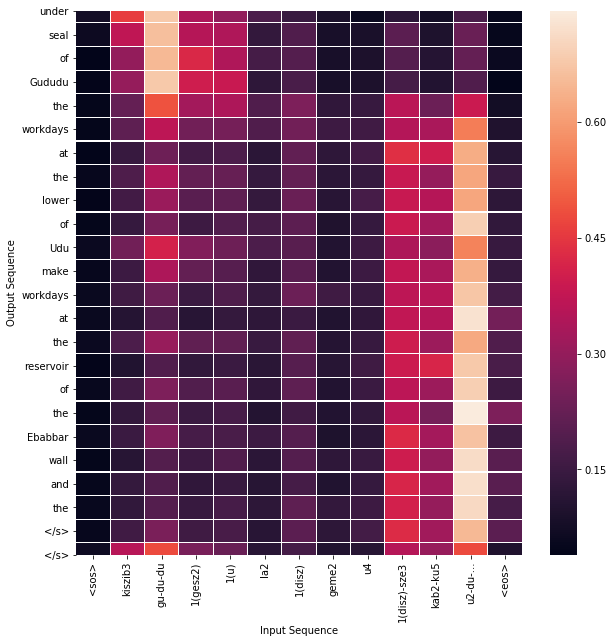

In [57]:
fig, ax = plt.subplots(figsize=(10,10))
xticklabels=['<sos>']+input_text.split()+['<eos>']
yticklabels=output_tokens
ax = sns.heatmap(np.array(attrs_sal), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2)
plt.xlabel('Input Sequence')
plt.ylabel('Output Sequence')
plt.savefig(save_name + '_salhm.png')
plt.show()

### All Embeddings

In [58]:
interpretable_embedding3 = configure_interpretable_embedding_layer(encoder, 'position_embeddings')
interpretable_embedding2 = configure_interpretable_embedding_layer(encoder, 'lang_embeddings')

In [59]:
ig = IntegratedGradients(nmt_forward_func)

In [60]:
def interpret_sentence(src, trg):
    
    # get a list of src_tokens from the src sentence
    input_ids, text_ids, ref_input_ids, sep_id = construct_input_ref_pair(input_text)
    lang_type_ids, ref_lang_type_ids = construct_input_ref_lang_type_pair(input_ids)
    position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
    
    langs = input_ids.reshape(-1,1).clone().fill_(src_id)
    lengths = torch.tensor([input_ids.shape[1]]*input_ids.shape[0])
    
    # get a list of trg_tokens from the trg sentence
    ground_truth_tokens = tokeniser([trg])
    
    langs2 = ground_truth_tokens.reshape(-1,1).clone().fill_(tgt_id)
    lengths2 = torch.tensor([ground_truth_tokens.shape[1]]*ground_truth_tokens.shape[0])
    
    # pre-computing word embeddings
    (input_embed, ref_input_embed), (token_lang_ids_embed, ref_lang_type_ids_embed), (position_ids_embed, ref_position_ids_embed) = construct_sub_embedding(input_ids, ref_input_ids, \
                                         token_lang_ids=lang_type_ids, ref_token_lang_ids=ref_lang_type_ids, \
                                         position_ids=position_ids, ref_position_ids=ref_position_ids)
    
    # get outputs tensor [seq_length, batch_size, trg_vocab_size]
    outputs = predict(input_embed, ground_truth_tokens, langs2, lengths2, token_lang_ids_embed, position_ids_embed, find_emb=False, all_embs=True, ret_out=False)
    
    # get output_tokens from outputs
    # compute attributions and approximation delta using integrated gradients
    output_tokens = []
    attribution_igs = [] # size: [len(output_tokens), len(src_tokens)]
    for idx, output in enumerate(outputs):
        print(idx)
        max_idx = output.max(1).indices.item()
        output_token = dico[max_idx]
        output_tokens.append(output_token)
        langs = langs.reshape(1,-1)
        langs2 = langs2.reshape(1,-1)
        attribution_ig, delta =  ig.attribute(input_embed, baselines=0, additional_forward_args=(ground_truth_tokens, langs2, lengths2, token_lang_ids_embed, idx, False, True, position_ids_embed), target=max_idx, n_steps=50, return_convergence_delta=True)
        attribution_igs.append(attribution_ig)
    
    return attribution_igs, output_tokens

In [61]:
attribution_igs_all, output_tokens_all = interpret_sentence(input_text, ground_truth)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [62]:
attrs_all = plot_attributions(attribution_igs_all, input_text, output_tokens_all)

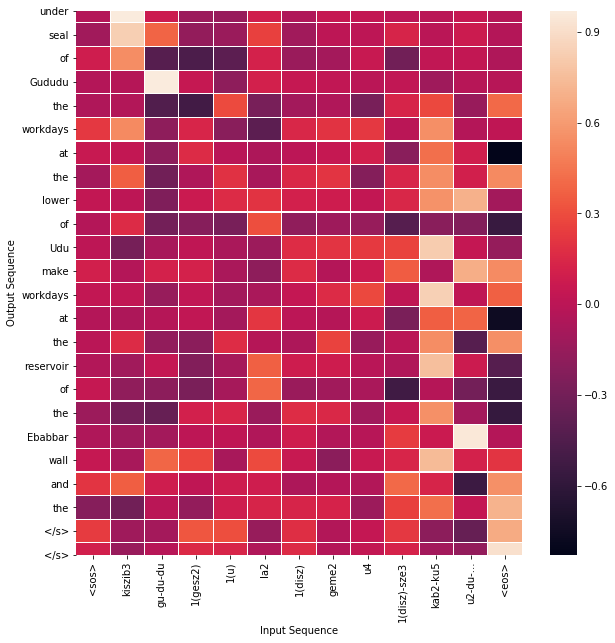

In [63]:
fig, ax = plt.subplots(figsize=(10,10))
xticklabels=['<sos>']+input_text.split()+['<eos>']
yticklabels=output_tokens
ax = sns.heatmap(np.array(attrs_all), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2)
plt.xlabel('Input Sequence')
plt.ylabel('Output Sequence')
plt.savefig(save_name + '_allhm.png')
plt.show()

In [64]:
input_ids

tensor([[   1,   53, 1271,    3,    3,   88,    3,  136,   38,    3,  919,    3,
            1]], device='cuda:0')

In [65]:
ground_truth_tokens

tensor([[    1,   202,   237,    28,     3, 12728,   395,   108,    24,  2355,
            28,    45, 14904,   395,   108,    24,  2355,    28,    24,   706,
           787,    54,    24,     1]])

### Vizualising

In [66]:
def interpret_sentence_viz(src, trg):
    
    # get a list of src_tokens from the src sentence
    input_ids, text_ids, ref_input_ids, sep_id = construct_input_ref_pair(input_text)
    lang_type_ids, ref_lang_type_ids = construct_input_ref_lang_type_pair(input_ids)
    position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
    
    langs = input_ids.reshape(-1,1).clone().fill_(src_id)
    lengths = torch.tensor([input_ids.shape[1]]*input_ids.shape[0])
    
    # get a list of trg_tokens from the trg sentence
    ground_truth_tokens = tokeniser([trg])
    
    langs2 = ground_truth_tokens.reshape(-1,1).clone().fill_(tgt_id)
    lengths2 = torch.tensor([ground_truth_tokens.shape[1]]*ground_truth_tokens.shape[0])
    
    # pre-computing word embeddings
    (input_embed, ref_input_embed), (token_lang_ids_embed, ref_lang_type_ids_embed), (position_ids_embed, ref_position_ids_embed) = construct_sub_embedding(input_ids, ref_input_ids, \
                                         token_lang_ids=lang_type_ids, ref_token_lang_ids=ref_lang_type_ids, \
                                         position_ids=position_ids, ref_position_ids=ref_position_ids)
    
    # get outputs tensor [seq_length, batch_size, trg_vocab_size]
    outputs = predict(input_embed, ground_truth_tokens, langs2, lengths2, token_lang_ids_embed, position_ids_embed, find_emb=False, all_embs=True, ret_out=False)
    
    # get output_tokens from outputs
    # compute attributions and approximation delta using integrated gradients
    output_tokens = []
    attribution_igs = [] # size: [len(output_tokens), len(src_tokens)]
    delta_igs = []
    
    for idx, output in enumerate(outputs):
        print(idx)
        max_idx = output.max(1).indices.item()
        output_token = dico[max_idx]
        output_tokens.append(output_token)
        langs = langs.reshape(1,-1)
        langs2 = langs2.reshape(1,-1)
        attribution_ig, delta =  ig.attribute(input_embed, baselines=0, additional_forward_args=(ground_truth_tokens, langs2, lengths2, token_lang_ids_embed, idx, False, True, position_ids_embed), target=max_idx, n_steps=50, return_convergence_delta=True)
        attribution_igs.append(attribution_ig)
        delta_igs.append(delta)
    
    return attribution_igs, outputs, output_tokens, delta_igs

In [67]:
attribution_igs_viz, scores_viz, out_viz, delta_viz = interpret_sentence_viz(input_text, ground_truth)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [68]:
len(attribution_igs_viz)

24

In [69]:
index=1

In [70]:
torch.argmax(scores_viz[index])

tensor(237, device='cuda:0', grad_fn=<NotImplemented>)

In [71]:
str(ground_truth_tokens[0][index].item())

'202'

In [72]:
len(ground_truth.split())

22

In [111]:
# %%capture cap --no-stderr
for index in range(24):
    viz_sum = summarize_attributions(attribution_igs_viz[index])

    start_position_vis = viz.VisualizationDataRecord(
                            viz_sum,
                            torch.max(torch.softmax(scores_viz[index][0], dim=0)),
                            torch.argmax(scores_viz[index]),
                            torch.argmax(scores_viz[index]),
                            str(ground_truth_tokens[0][index].item()),
                            viz_sum.sum(),       
                            ['<s>'] + input_text.split() + ['<e>'],
                            delta_viz[index])

    print('\033[1m', 'Visualizations For Output Word: ', out_viz[index], '\033[0m')
    viz.visualize_text([start_position_vis])

 Visualizations For Output Word:  under 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
202,202 (1.00),1,0.89,#s kiszib3 gu-du-du 1(gesz2) 1(u) la2 1(disz) geme2 u4 1(disz)-sze3 kab2-ku5 u2-du-... #e


 Visualizations For Output Word:  seal 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
237,237 (1.00),202,1.14,#s kiszib3 gu-du-du 1(gesz2) 1(u) la2 1(disz) geme2 u4 1(disz)-sze3 kab2-ku5 u2-du-... #e


 Visualizations For Output Word:  of 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
28,28 (0.98),237,-1.01,#s kiszib3 gu-du-du 1(gesz2) 1(u) la2 1(disz) geme2 u4 1(disz)-sze3 kab2-ku5 u2-du-... #e


 Visualizations For Output Word:  Gududu 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
3261,3261 (1.00),28,0.82,#s kiszib3 gu-du-du 1(gesz2) 1(u) la2 1(disz) geme2 u4 1(disz)-sze3 kab2-ku5 u2-du-... #e


 Visualizations For Output Word:  the 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
24,24 (0.99),3,-0.78,#s kiszib3 gu-du-du 1(gesz2) 1(u) la2 1(disz) geme2 u4 1(disz)-sze3 kab2-ku5 u2-du-... #e


 Visualizations For Output Word:  workdays 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
395,395 (0.81),12728,1.20,#s kiszib3 gu-du-du 1(gesz2) 1(u) la2 1(disz) geme2 u4 1(disz)-sze3 kab2-ku5 u2-du-... #e


 Visualizations For Output Word:  at 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
108,108 (0.75),395,-0.37,#s kiszib3 gu-du-du 1(gesz2) 1(u) la2 1(disz) geme2 u4 1(disz)-sze3 kab2-ku5 u2-du-... #e


 Visualizations For Output Word:  the 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
24,24 (1.00),108,1.46,#s kiszib3 gu-du-du 1(gesz2) 1(u) la2 1(disz) geme2 u4 1(disz)-sze3 kab2-ku5 u2-du-... #e


 Visualizations For Output Word:  lower 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
6818,6818 (0.30),24,1.75,#s kiszib3 gu-du-du 1(gesz2) 1(u) la2 1(disz) geme2 u4 1(disz)-sze3 kab2-ku5 u2-du-... #e


 Visualizations For Output Word:  of 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
28,28 (1.00),2355,-2.24,#s kiszib3 gu-du-du 1(gesz2) 1(u) la2 1(disz) geme2 u4 1(disz)-sze3 kab2-ku5 u2-du-... #e


 Visualizations For Output Word:  Udu 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
45673,45673 (0.98),28,1.02,#s kiszib3 gu-du-du 1(gesz2) 1(u) la2 1(disz) geme2 u4 1(disz)-sze3 kab2-ku5 u2-du-... #e


 Visualizations For Output Word:  make 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
355,355 (0.35),45,1.77,#s kiszib3 gu-du-du 1(gesz2) 1(u) la2 1(disz) geme2 u4 1(disz)-sze3 kab2-ku5 u2-du-... #e


 Visualizations For Output Word:  workdays 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
395,395 (0.36),14904,1.50,#s kiszib3 gu-du-du 1(gesz2) 1(u) la2 1(disz) geme2 u4 1(disz)-sze3 kab2-ku5 u2-du-... #e


 Visualizations For Output Word:  at 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
108,108 (1.00),395,-0.21,#s kiszib3 gu-du-du 1(gesz2) 1(u) la2 1(disz) geme2 u4 1(disz)-sze3 kab2-ku5 u2-du-... #e


 Visualizations For Output Word:  the 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
24,24 (1.00),108,0.66,#s kiszib3 gu-du-du 1(gesz2) 1(u) la2 1(disz) geme2 u4 1(disz)-sze3 kab2-ku5 u2-du-... #e


 Visualizations For Output Word:  reservoir 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2355,2355 (0.91),24,0.45,#s kiszib3 gu-du-du 1(gesz2) 1(u) la2 1(disz) geme2 u4 1(disz)-sze3 kab2-ku5 u2-du-... #e


 Visualizations For Output Word:  of 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
28,28 (0.99),2355,-2.01,#s kiszib3 gu-du-du 1(gesz2) 1(u) la2 1(disz) geme2 u4 1(disz)-sze3 kab2-ku5 u2-du-... #e


 Visualizations For Output Word:  the 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
24,24 (0.90),28,-0.52,#s kiszib3 gu-du-du 1(gesz2) 1(u) la2 1(disz) geme2 u4 1(disz)-sze3 kab2-ku5 u2-du-... #e


 Visualizations For Output Word:  Ebabbar 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2650,2650 (0.31),24,0.97,#s kiszib3 gu-du-du 1(gesz2) 1(u) la2 1(disz) geme2 u4 1(disz)-sze3 kab2-ku5 u2-du-... #e


 Visualizations For Output Word:  wall 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
787,787 (1.00),706,1.94,#s kiszib3 gu-du-du 1(gesz2) 1(u) la2 1(disz) geme2 u4 1(disz)-sze3 kab2-ku5 u2-du-... #e


 Visualizations For Output Word:  and 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
54,54 (0.95),787,1.27,#s kiszib3 gu-du-du 1(gesz2) 1(u) la2 1(disz) geme2 u4 1(disz)-sze3 kab2-ku5 u2-du-... #e


 Visualizations For Output Word:  the 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
24,24 (0.89),54,1.08,#s kiszib3 gu-du-du 1(gesz2) 1(u) la2 1(disz) geme2 u4 1(disz)-sze3 kab2-ku5 u2-du-... #e


 Visualizations For Output Word:  </s> 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,1 (0.98),24,1.04,#s kiszib3 gu-du-du 1(gesz2) 1(u) la2 1(disz) geme2 u4 1(disz)-sze3 kab2-ku5 u2-du-... #e


 Visualizations For Output Word:  </s> 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,1 (1.00),1,1.13,#s kiszib3 gu-du-du 1(gesz2) 1(u) la2 1(disz) geme2 u4 1(disz)-sze3 kab2-ku5 u2-du-... #e
